# Materialize dataset

* **Inputs:** The accompanying datasets from several sources: 
    * The [World Bank](https://data.worldbank.org/). The data is fetched by the notebook, `download_wb_data.ipynb`. 
    * Acemoglu, Naidu, Restrepo and Robinson (2019): "Democracy Does Cause Growth", [JPE](https://www.journals.uchicago.edu/doi/full/10.1086/700936?mobileUi=0)
    * Assenova and Regele (2017): "Revisiting the effect of colonial institutions on comparative economic development", [PLOS](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5421788/) 
    * Ashraf and Galor (2013): "The 'Out of Africa' Hypothesis, Human Genetic Diversity, and Comparative Economic Development" [AER](https://www.aeaweb.org/articles?id=10.1257/aer.103.1.1)
* **Output:** 
    * `growth.csv`: Primary dataset for analysis. 
    * `labels.csv`: Variable descriptions. 
    
* Dependencies: 
    * `geopandas`: Should be version 0.9.0 or higher(!). This may require `pip install geopandas --upgrade`, since the basic install sometimes does not grab the most recent version. 

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import geopandas
import os

# user-written file with variable labels
import labels

In [2]:
# check that required files exist 
assert os.path.isdir('./input'), f'Current directory must have a folder, "input", where the input data should be'
for f in ['world_bank.csv', 'DDCGdata_final.dta', 'complete.data.iv.csv', 'country.dta']:
    assert os.path.isfile(f'./input/{f}'), f'File, "{f}", not found in folder ./input/.'    

## Key decision: initial and current years

In [3]:
year0 = 1970 # the "initial" year 
year1 = 2020 # "now"

# Helpful functions 

Printing information about constructed datasets

In [4]:
def print_info(cols, dat): 
    for c in cols: 
        assert c in dat.columns, f'Col {c} not found in dat'
    
    x_ = dat[cols].notnull().sum()
    print(f'Picked {len(cols)} vars, ') 
    print(x_.to_frame('No. countries observed'))

### For plotting maps

In [5]:
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# Fix errors in geopandas (tsk!)
if world.query('name == "France"').iso_a3.values[0] == '-99': 
    world.loc[world.name == "France", 'iso_a3'] = 'FRA'
if world.query('name == "Norway"').iso_a3.values[0] == '-99': 
    world.loc[world.name == "Norway", 'iso_a3'] = 'NOR'

def remove_bounding(ax): 
    ax.set_yticklabels([]);
    ax.set_xticklabels([]); 
    ax.set_xticks([]);
    ax.set_yticks([]);
    for l in ['top', 'bottom', 'left', 'right']:
        ax.spines[l].set_visible(False)

def plot_world_map(var, dat, lbl=None, title=None, fname=None, **kwargs):
    assert var in dat.columns, f'Variable "{var}" not in dat columns'
    assert 'code' in dat.columns , f'ISO3 country variable, "code", not found in dat'
    
    # name for chosen variable 
    lbl_var = var # default: just show the variable name 
    if (not lbl is None): 
        if isinstance(lbl, str): 
            lbl_var = lbl 
        elif var in lbl: 
            lbl_var = lbl[var]
        else: 
            print(f'(Var "{var}" not in lbl)')
        
    cols = ['code'] + [var]
    w = pd.merge(world, dat[cols], left_on='iso_a3', right_on='code')
    ax = w.plot(var, cmap = 'OrRd', legend=True, missing_kwds={'color': 'lightgrey', 'label':'hej'},
                 legend_kwds={'label': lbl_var,'orientation': "horizontal"}, **kwargs);
    remove_bounding(ax)
    if not title is None: 
        ax.set_title(title)
    if not fname is None: 
        plt.savefig(fname)

# Acemoglu, Naidu, Restrepo and Robinson (2019): *Democracy Does Cause Growth* 

**Note:** This dataset is actually a panel, but we just extract the data for our chosen year `year0`.

In [6]:
fname = 'input/DDCGdata_final.dta'
dat_anrr = pd.read_stata(fname)
#lbl_anrr = pd.read_stata(fname, iterator=True).variable_labels() # this has too many missing labels 
lbl_anrr = labels.lbl_anrr # a dictionary, typed by hand

C:\Users\JBH\AppData\Local\Temp\ipykernel_5380\2073420643.py:2: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  dat_anrr = pd.read_stata(fname)


In [7]:
cols_del = [c for c in dat_anrr.columns if (c == 'country_name') or (c[:2] == 'yy') or (c[:4] == 'd60_') or (c[:4] == 'dDA_') or (c[:4] == 'dFY_')
            or (c[:6] == 'rtrend') or (c[:5] == 'dREG_') or (c[:6] == 'regdum') or (c[:9] == 'interfull')]
dat_anrr.drop(cols_del, axis=1, inplace=True)

# rename the key ID variables for countries
ren = {'wbcode':'code'}
dat_anrr.rename(columns=ren, inplace=True)

dat_anrr.year = dat_anrr.year.astype(int)

print(f'ANRR data: N={dat_anrr.code.unique().size}, T={dat_anrr.year.unique().size}: {dat_anrr.columns.size} variables')

ANRR data: N=184, T=51: 127 variables


## Primary vairables

As a warmup, note that market reforms primarily happened from the 1990s across the world. However, we will only be using the 1960 snapshot.

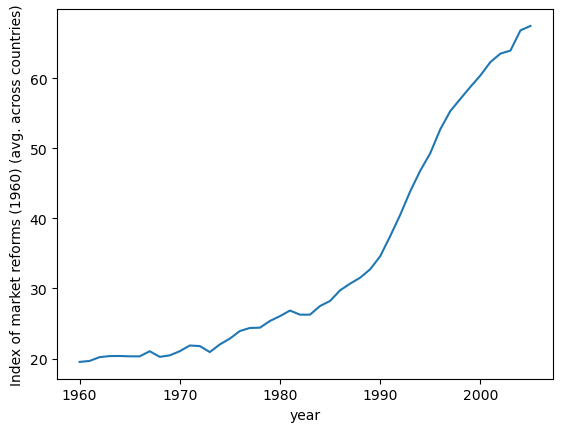

In [8]:
var = 'marketref'
ax=dat_anrr.groupby('year')[var].mean().plot();
ax.set_ylabel(f'{lbl_anrr[var]} (avg. across countries)');

In [9]:
I = dat_anrr.year == year0

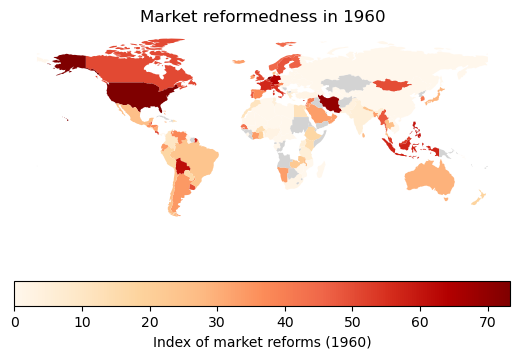

In [10]:
plot_world_map('marketref', dat_anrr[I], lbl_anrr, title='Market reformedness in 1960')

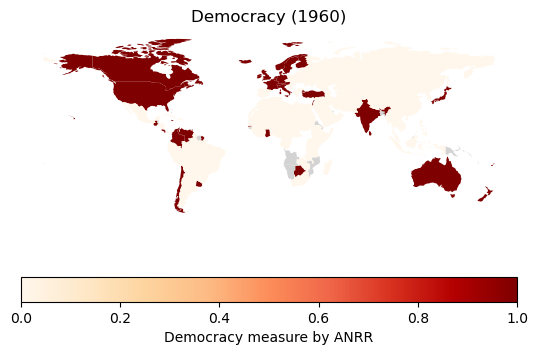

In [11]:
plot_world_map('dem', dat_anrr[I], lbl_anrr, title='Democracy (1960)')

In [12]:
cols_anrr = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg', # institutions
             'lp_bl', 'ls_bl', 'lh_bl', # education
             'tropicar', 'distcr', 'distc', 'distr', # geography 
            ]
cols_anrr_extra = ['ginv', 'polity', 'polity2']

lbl_anrr['polity'] = 'Polity (measure of democracy)'
lbl_anrr['polity2'] = 'Polity 2 (measure of democracy)'

print_info(cols_anrr, dat_anrr[I])

Picked 12 vars, 
           No. countries observed
marketref                     136
dem                           155
demCGV                        150
demBMR                        154
demreg                        183
lp_bl                         143
ls_bl                         143
lh_bl                         143
tropicar                      159
distcr                        159
distc                         159
distr                         159


# Assenova and Regele (2017): *Revisiting the effect of colonial institutions on comparative economic development*

**Note:** This paper and the dataset explores a previous paper, by Acemoglu, Johnson, and Robinson (2001, *AER*): *"The Colonial Origins of Comparative Development: An Empirical Investigation"*. 

In [13]:
dat_ar = pd.read_csv('input/complete.data.iv.csv', encoding='latin1')
lbl_ar = labels.lbl_ar

ren = {'shortnam':'code', 'name':'country'}
dat_ar.rename(columns=ren, inplace=True)

In [14]:
cols_ar = ['landlock', 'yellow' , 'oilres', 'goldm', 'iron', 'silv', 'zinc']
cols_ar_extra = ['mortality', # this removes the largest number of observations from the sample 
                 'imputedmort', 'logem4', 'excolony', 'lt100km', 'democ1', 'democ00a', 'cons00a']

# some additional variables that might be thought of as outcomes
outcomes_ar = ['currentinst', 'imr95', 'leb95']

In [15]:
print_info(cols_ar, dat_ar)

Picked 7 vars, 
          No. countries observed
landlock                     163
yellow                       163
oilres                       154
goldm                        159
iron                         159
silv                         159
zinc                         159


In [16]:
print_info(cols_ar_extra, dat_ar)

Picked 8 vars, 
             No. countries observed
mortality                        61
imputedmort                      78
logem4                           87
excolony                         78
lt100km                          61
democ1                           87
democ00a                         87
cons00a                          91


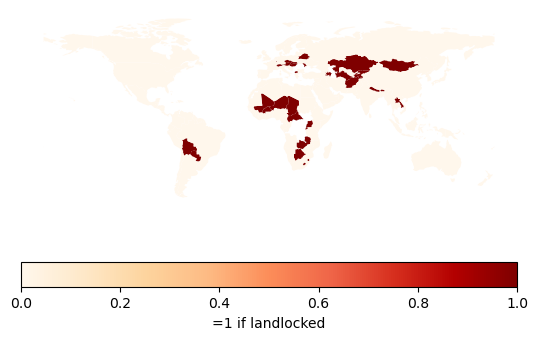

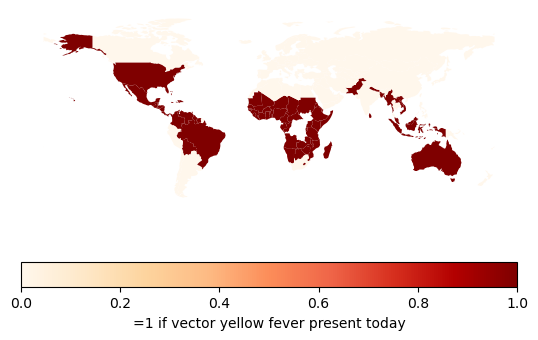

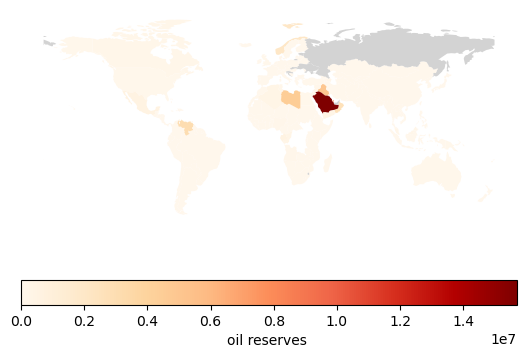

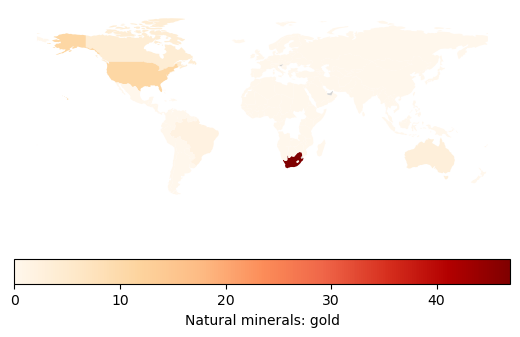

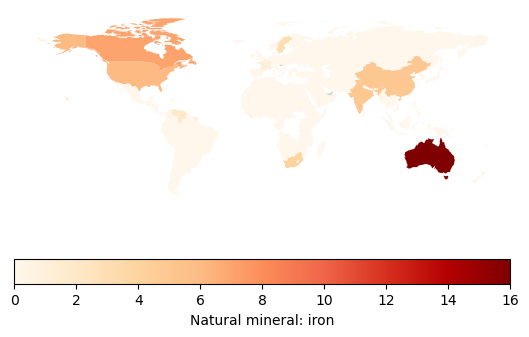

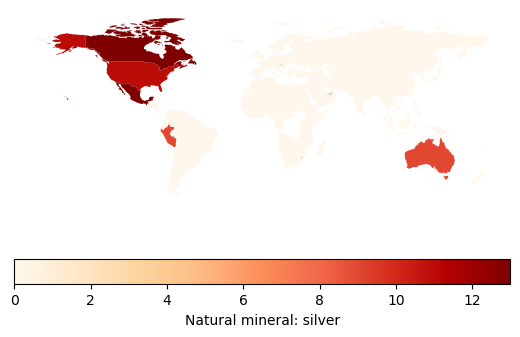

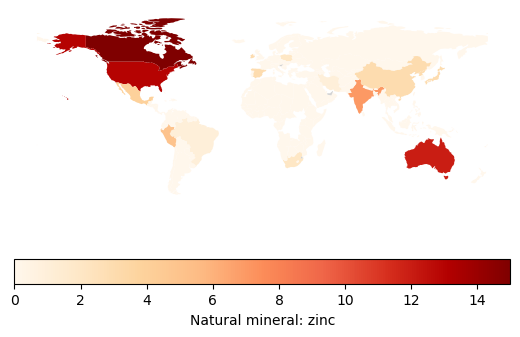

In [17]:
for c in cols_ar: 
    plot_world_map(c, dat_ar, lbl_ar);

### Settler mortality

Key variable in AJR (2001, but not observed as widely as some other variables.


Settler mortality, observed for N = 87 countries


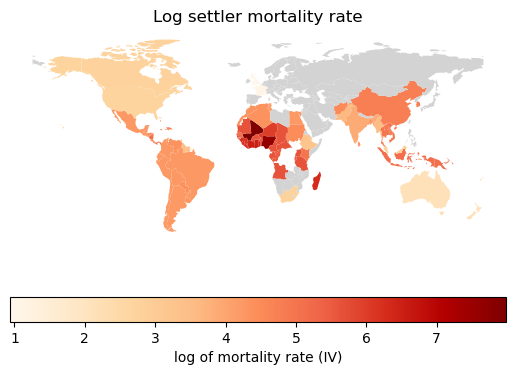

In [18]:
print(f'Settler mortality, observed for N = {dat_ar.logem4.notnull().sum()} countries')
plot_world_map('logem4', dat_ar, lbl_ar, title='Log settler mortality rate');

# Ashraf and Galor (2013 AER): *The 'Out of Africa' Hypothesis, Human Genetic Diversity, and Comparative Economic Development*

In [19]:
fname = 'input/country.dta'
dat_ag = pd.read_stata(fname)
lbl_ag = pd.read_stata(fname, iterator=True).variable_labels() # these labels work fine

cols_drop = [c for c in dat_ag.columns if (lbl_ag[c] == 'Sample flag') # subsample indicators
             or (c[:6] == 'mdist_') or (c[:8] == 'hmicost_') 
             or (c[:7] == 'conley_') # used for some robustness
             or (c[-4:] == '_sqr') # squares of variables
            ]

dat_ag.drop(cols_drop, axis=1, inplace=True)

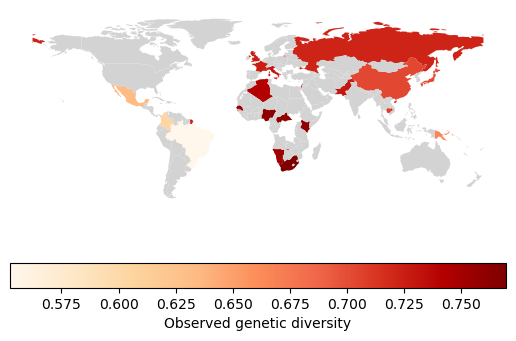

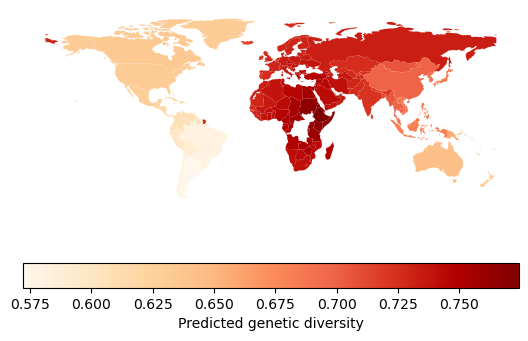

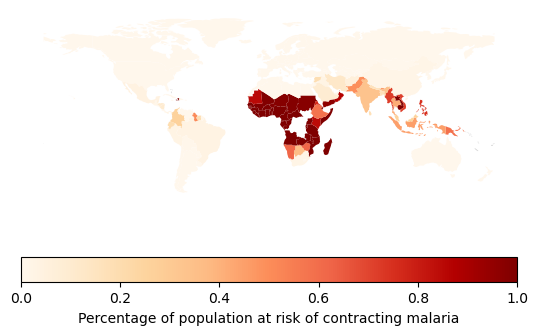

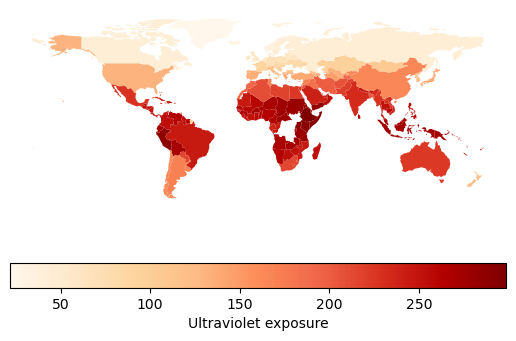

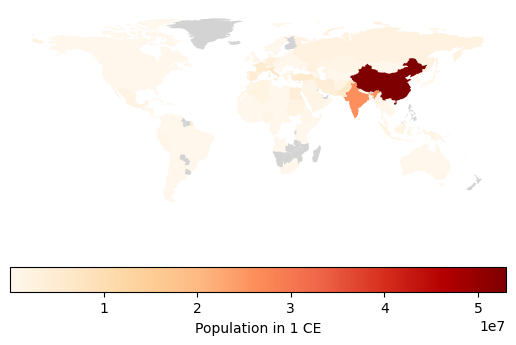

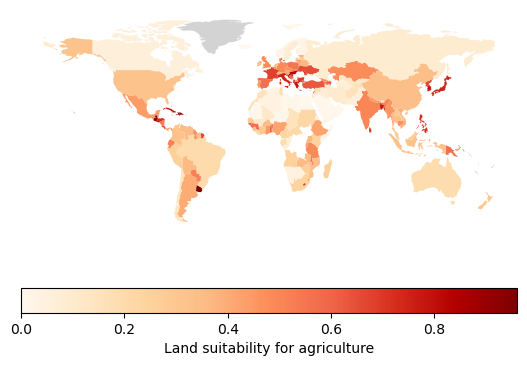

In [20]:
for v in ['adiv', 'pdiv', 'malfal', 'uvdamage', 'pop1', 'suitavg']:
    plot_world_map(v, dat_ag, lbl_ag)

In [21]:
cols_ag = ['malfal', 'uvdamage', 'suitavg', 
           'pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa',
           'pd1', 'pd1000', 'pd1500', 'pd1500', 'pop1', 'pop1000', 'pop1500',
           'legor_uk', 'legor_fr', 'temp', 
           'elevavg', 'elevstd', 'kgatr', 'precip','suitgini', 
           'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'ln_yst', 'ln_yst_aa',
           'africa', 'europe', 'asia', 'oceania', 'americas', 
          'pprotest', 'pcatholic', 'pmuslim', 'pother' # religion
          ]
x_ = dat_ag[cols_ag].notnull().sum()
print(f'Picked {len(cols_ag)} vars, ') 
x_.to_frame('No. countries observed')

Picked 38 vars, 


,No. countries observed
malfal,164
uvdamage,207
suitavg,155
pdiv,207
pdiv_aa,164
pdivhmi,139
pdivhmi_aa,132
pd1,155
pd1000,177
pd1500,184


# World Bank data

In [22]:
wb_raw = pd.read_csv('./input/world_bank.csv') 
I = wb_raw.year.isin([year0,year1]) # only keep the two years that we will be focusing on 
wb = wb_raw[I].set_index(['code', 'year']).unstack() # from long to wide format 
f_ = {year0: 'initial', year1: 'now'} # rename the year variables 
wb.columns = [f'{x}_{f_[y]}' for x,y in wb.columns ] # flatten multiindex columns 
wb.sample(3)

,population_initial,population_now,gdp_pc_initial,gdp_pc_now,capital_growth_pct_gdp_initial,capital_growth_pct_gdp_now,gdp_initial,gdp_now
code,,,,,,,,
SLV,3673066.0,6486201.0,2554.184382,3279.496516,13.247184,17.906206,9.381688e+09,2.127147e+10
VEN,11396396.0,28435943.0,14570.097034,NaN,36.549928,NaN,1.660466e+11,NaN
FRO,39008.0,48865.0,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
lbl_wb = dict()

for t,y in zip(['initial', 'now'], [year0, year1]): 
    lbl_wb[f'population_{t}'] = f'Population in {y}'
    lbl_wb[f'gdp_pc_{t}'] = f'GDP per capita in {y}'
    lbl_wb[f'gdp_{t}'] = f'GDP in {y}'
    lbl_wb[f'capital_growth_pct_gdp_{t}'] = f'Gross capital formation in {y} (% of GDP)'

Compute the average annual capital growth rate for each country: this can be interpreted as the rate of investment

In [24]:
wb['investment_rate'] = wb_raw.groupby('code').capital_growth_pct_gdp.mean()
lbl_wb['investment_rate'] = f'Capital formation (% of GDP per year, avg. of available years {year0}-{year1})'

# Merge all data

In [25]:
I = dat_anrr.year == year0
c = ['code']

dat = pd.merge(dat_anrr[I][c + cols_anrr + cols_anrr_extra], 
               dat_ar[c + cols_ar + cols_ar_extra + outcomes_ar], on='code', how='outer').sort_values('code')
dat = pd.merge(dat, dat_ag[c + cols_ag], on='code', how='outer')
dat = pd.merge(dat, wb, on='code', how='left') 

Computing compound annual growth rates: 
$$ g = \left( \frac{y_T}{y_1} \right)^{\frac{1}{T}} - 1 $$

In [26]:
def annual_growth_rate(dat, x1, x0):
    """ Calculate compound growth rate from x0 to x """      
    num_periods = year1-year0 #used from global memory 
    return (dat[x1]/dat[x0])**(1./num_periods)-1.

In [27]:
dat['gdp_growth'] = annual_growth_rate(dat, 'gdp_pc_now', 'gdp_pc_initial') 
dat['pop_growth'] = annual_growth_rate(dat, 'population_now', 'population_initial')  #dat.population_now / dat.population_initial - 1.0
dat['lgdp_initial'] = np.log(dat['gdp_pc_initial'])
dat['lpop_initial'] = np.log(dat.population_initial)

In [28]:
# add to labels
lbl_wb['lgdp_initial'] = f'GDP per capita in {year0} (log)'
lbl_wb['lgdp_now']     = f'GDP per capita in {year1} (log)'
lbl_wb['lpop_initial'] = f'Population in {year0} (log)'
lbl_wb['lpop_now']     = f'Population in {year1} (log)'
lbl_wb['gdp_growth'] = f'Annual growth in GDP per capita, {year0}-{year1}'
lbl_wb['pop_growth'] = f'Annual growth in population, {year0}-{year1}'

In [29]:
print(f'Final data has N={dat.shape[0]} and {dat.shape[1]} vars. GDP growth observed for {dat.gdp_growth.notnull().sum()} countries')

Final data has N=214 and 85 vars. GDP growth observed for 102 countries


# Save to disk 

In [30]:
dat.to_csv('growth.csv', index=False)

### Labels

In [31]:
pd.DataFrame.from_dict(lbl_anrr, orient='index')

,0
country_name,Country name
wbcode,World Bank country code
year,Year (from 1960 to 2010)
gdppercapitaconstant2000us,"GDP per capita (constant 2000 US$, from World ..."
lp_bl,Percentage of population with at most primary ...
...,...
rgdpl2,rgdpl2
rgdpna_full,rgdpna_full
PopulationtotalSPPOPTOTL,"Population, total [SP.POP.TOTL]"
Populationages014oftotal,Population ages 0-14 (% of total) [SP.POP.0014...


In [32]:
# Avoiding duplicates in the full list of labels: 
# some variables appear with exactly the same names in several datasets 
del lbl_ar['africa'] # we take this from AG 
del lbl_ar['asia']   # we take this from AG 
del lbl_ag['distcr'] # we take this from ANRR 

In [33]:
lbldf = [] 
for lbl,name in zip([lbl_anrr, lbl_ar, lbl_ag, lbl_wb],
                    ['ANRR', 'AR', 'AG', 'WB']): 
    
    # convert index->df 
    df = pd.DataFrame.from_dict(lbl, orient='index')
    df.index.name = 'variable'
    df.columns = ['label']
    
    # add name of the data source 
    df['Source'] = name
    lbldf.append(df)

# collect 
lbldf = pd.concat(lbldf)

In [34]:
# 1. merge all the label dictionaries into one.
lbl_all = dict()
lbl_all.update(lbl_anrr)
lbl_all.update(lbl_ar)
lbl_all.update(lbl_ag)
lbl_all.update(lbl_wb)

In [35]:
tab = dat.notnull().sum().to_frame('Obs.')
tab.index.name = 'Variable'
tab['Description'] = 'n.a.'
I = tab.index.isin(lbl_all)
tab.loc[I, 'Description'] = tab[I].index.map(lbl_all) # look up in the dictionary
tab = tab.join(lbldf[['Source']]) # add the source of the data 

pd.options.display.max_colwidth = 200 # otherwise, strings get truncated
tab.loc[:, ['Description', 'Source', 'Obs.']].to_latex('tab/labels_raw.tex')

C:\Users\JBH\AppData\Local\Temp\ipykernel_5380\2488309091.py:9: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  tab.loc[:, ['Description', 'Source', 'Obs.']].to_latex('tab/labels_raw.tex')


# Some descriptives 

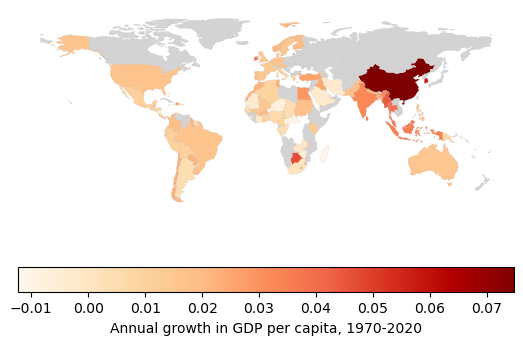

In [36]:
plot_world_map('gdp_growth', dat, lbl=lbl_all, edgecolor=(.7,.7,.7), linewidth=0.1)

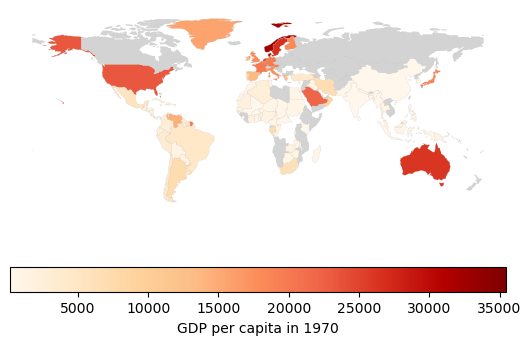

In [37]:
plot_world_map('gdp_pc_initial', dat, lbl=lbl_all, edgecolor=(.7,.7,.7), linewidth=0.1)

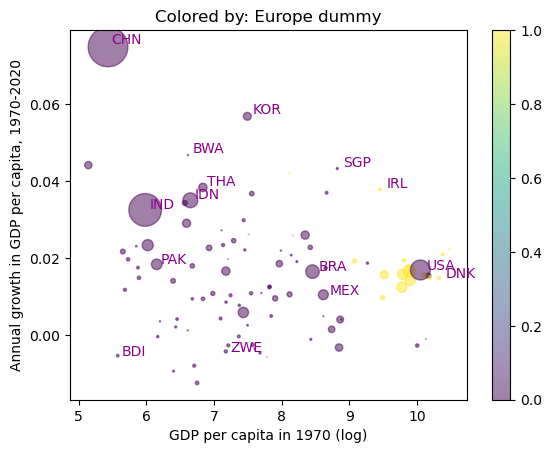

In [38]:
s = dat.population_initial/1_000_000
color_var = 'europe' # color dots acoording to this variable
ax=dat.plot.scatter(x='lgdp_initial', y='gdp_growth', s=s, c=dat[color_var], alpha=0.5, cmap='plasma');

# print the names for these countries 
countries = ['CHN', 'KOR', 'BWA', 'USA', 'PAK', 'SGP', 'IRL', 'THA', 'IDN', 'COD', 
             'ROM', 'POL', 'MEX', 'IND', 'VNM', 'BDI', 'ZWE', 'BRA', 'DNK']
J = dat.code.isin(countries) & dat.gdp_growth.notnull() & dat.lgdp_initial.notnull()
for i,row in dat[J].iterrows(): 
    ax.text(row.lgdp_initial*1.01, row.gdp_growth*1.01, row.code, c='darkmagenta')

# labels
ax.set_xlabel(lbl_all['lgdp_initial']); 
ax.set_ylabel(lbl_all['gdp_growth']);
ax.set_title(f'Colored by: {lbl_all[color_var]}');

## Missings

### Variables by categories

In [39]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg']
vv_geography = [
       'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
      'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough',
        'landlock', 'africa', 'europe', 'asia', 'oceania', 'americas'
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1', 'pd1000', 'pd1500', 'pop1', 'pop1000', 'pop1500', 'ln_yst']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
# vv_educ = ['lp_bl', 'ls_bl', 'lh_bl'] # perhaps more of an outcome

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


### Count nonmissings

Out of countries with GDP growth observed, how many have each var. observed?


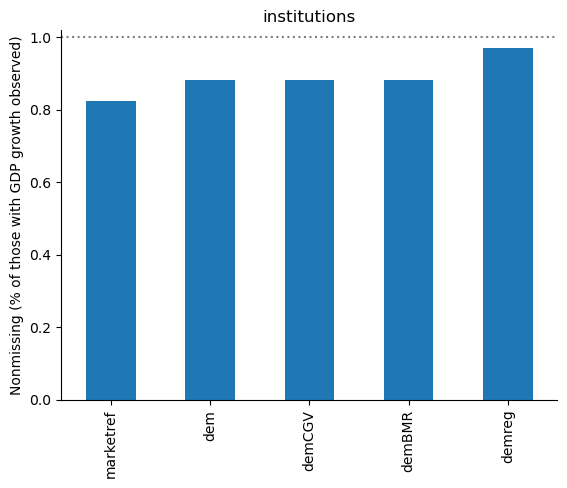

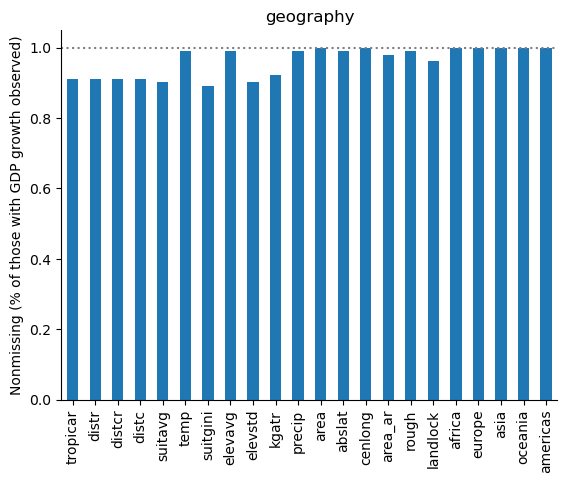

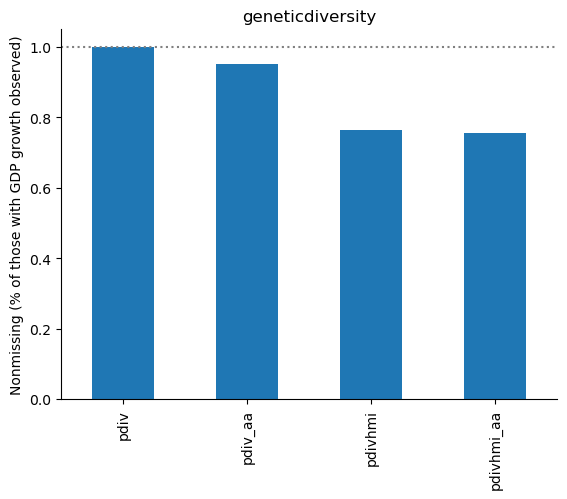

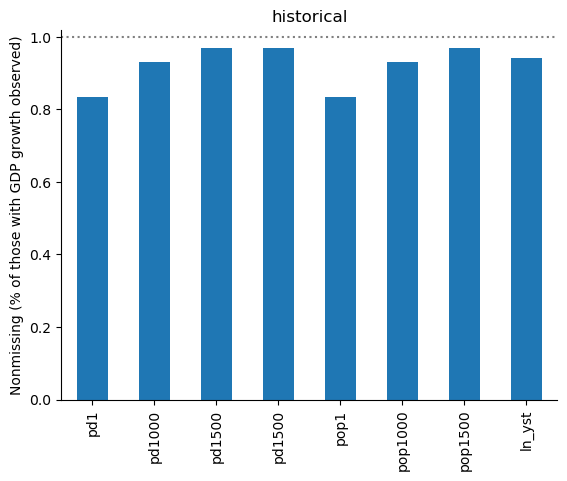

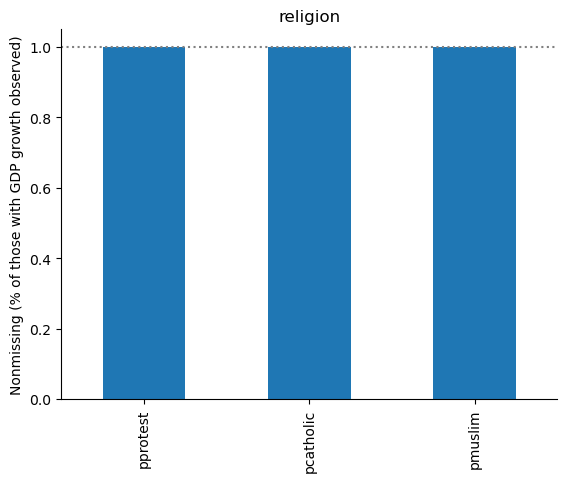

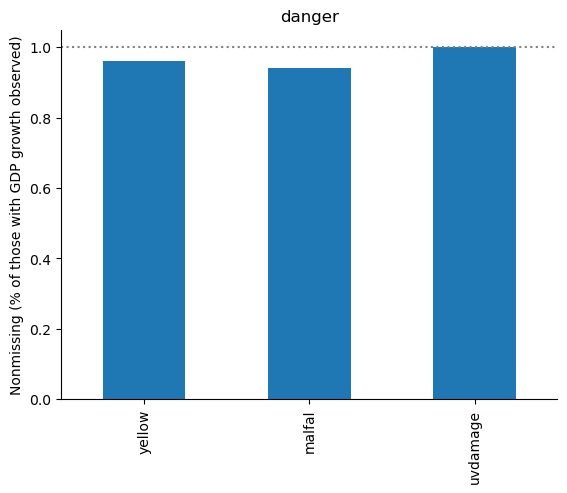

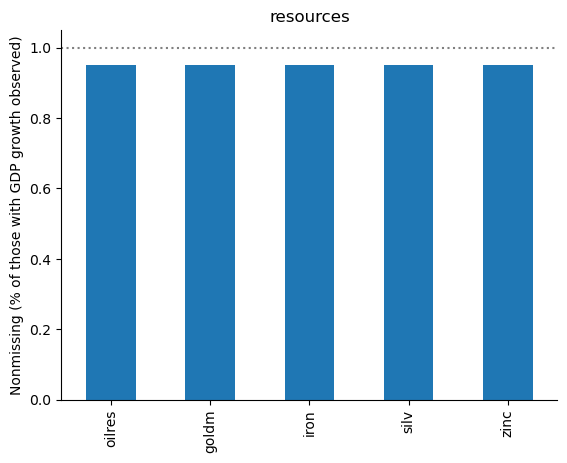

In [40]:
print(f'Out of countries with GDP growth observed, how many have each var. observed?')
for nam,v in vv_all.items(): 
    if nam == 'all': 
        continue
    ax=dat[dat.gdp_growth.notnull()][v].notnull().mean().plot(kind='bar');
    ax.set_title(nam); ax.set_ylabel('Nonmissing (% of those with GDP growth observed)');
    for pos in ['top', 'right']:
        ax.spines[pos].set_visible(False)
    ax.axhline(1.0, color='gray', linestyle=':');
    plt.show();